In [1]:
# %%
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../..'))

################################################
# Arguments
################################################

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=123, help='Random seed for model')
parser.add_argument('--dataset', type=str, default='citeseer', help='dataset')

parser.add_argument('--model_lr', type=float, default=0.01, help='Initial learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters)')
parser.add_argument('--hidden_layers', type=int, default=32, help='Number of hidden layers')
parser.add_argument('--dropout', type=float, default=0.5, help='Dropout rate for GCN')

parser.add_argument('--protect_size', type=float, default=0.1, help='Number of randomly chosen protected nodes')
parser.add_argument('--ptb_rate', type=float, default=0.25, help='Perturbation rate (percentage of available edges)')

parser.add_argument('--sample_size', type=int, default=500, help='')
parser.add_argument('--num_samples', type=int, default=20, help='')
parser.add_argument('--num_subtasks', type=int, default=10, help='')
parser.add_argument('--top', type=str, default='Y', help='sample top (Y) or random')

parser.add_argument('--reg_epochs', type=int, default=100, help='Epochs to train models')
parser.add_argument('--ptb_epochs', type=int, default=30, help='Epochs to perturb adj matrix')
parser.add_argument('--surrogate_epochs', type=int, default=0, help='Epochs to train surrogate before perturb')

parser.add_argument('--save', type=str, default='N', help='save the outputs to csv')
parser.add_argument('--save_location', type=str, default="./UniversalProtection.csv", help='where to save the outputs to csv')

args = parser.parse_args("") # Remove string if file

In [2]:
# %%
################################################
# Environment
################################################

import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if device != 'cpu':
    torch.cuda.manual_seed(args.seed)

print('==== Environment ====')
print(f'  torch version: {torch.__version__}')
print(f'  device: {device}')
print(f'  torch seed: {args.seed}')

==== Environment ====
  torch version: 1.10.2
  device: cpu
  torch seed: 123


In [3]:
################################################
# Dataset
################################################

from Utils import GraphData
from Utils import Metrics
import numpy as np

print(f'==== Dataset: {args.dataset} ====')

graph = GraphData.getGraph("../../Datasets", args.dataset, "gcn", args.seed, device)

graph.summarize()

==== Dataset: citeseer ====
Loading citeseer dataset...

==== Dataset Summary:  ====
adj shape: [3312, 3312]
feature shape: [3312, 3703]
num labels: 6
split seed: 123
train|val|test: 120|500|1000


In [4]:
# %%
from Utils import Utils

tasks = {}
np.seterr(invalid='ignore')

# Find highest entropy
entropy, correlation, idx = Metrics.get_ent_cor(graph.features, graph.labels, graph.features.shape[1], args.top != 'Y')

/var/folders/_k/zv52j1ld3yg7rl1m5gz2hkgc0000gn/T/ipykernel_18431/1626515515.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


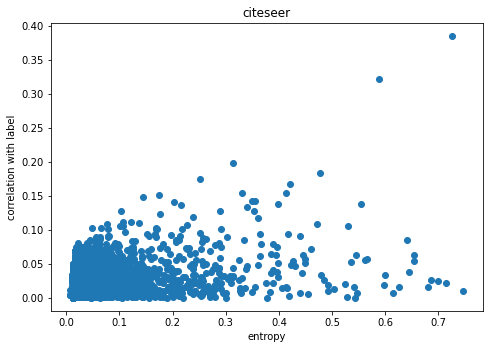

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(entropy, correlation)
ax.set_xlabel('entropy')
ax.set_ylabel('correlation with label')
ax.set_title(args.dataset)
fig.show()

In [10]:
torch.tensor([1, 2, 3, 4, 5])[2:]

tensor([3, 4, 5])